# Dominik 2024

In [1]:
%load_ext autoreload
%autoreload 2

import os
ROOT_DIR = os.getcwd()[:os.getcwd().rfind('NVcenter')]+ 'NVcenter'
os.chdir(ROOT_DIR)

from NVcenter import *
plt.style.use('NVcenter-default')

import numpy as np 
import matplotlib.pyplot as plt
import qutip as q

In [2]:
C13_pos = (8.728883757198979e-10, 0.0, 1.8558998769620693e-10) # Dominik
register_config = [('NV', (0, 0, 0), 0, {}), ('C13', C13_pos, 0, {})]

directory = os.path.join(os.getcwd(), "baths")
filename = "dominik_bath_small"
bath_configs_nested = load_spin_baths(filename, directory)
bath_configs = [item for sublist in bath_configs_nested for item in sublist]

init_state = q.tensor( q.fock_dm(2,0), q.fock_dm(2,0) )
bell_gate = get_cnot_gate(2, 0, 1) * get_hada_gate(2, 0)
bell_state = bell_gate * init_state * bell_gate.dag()

## Effect of the spin bath for free time evolution

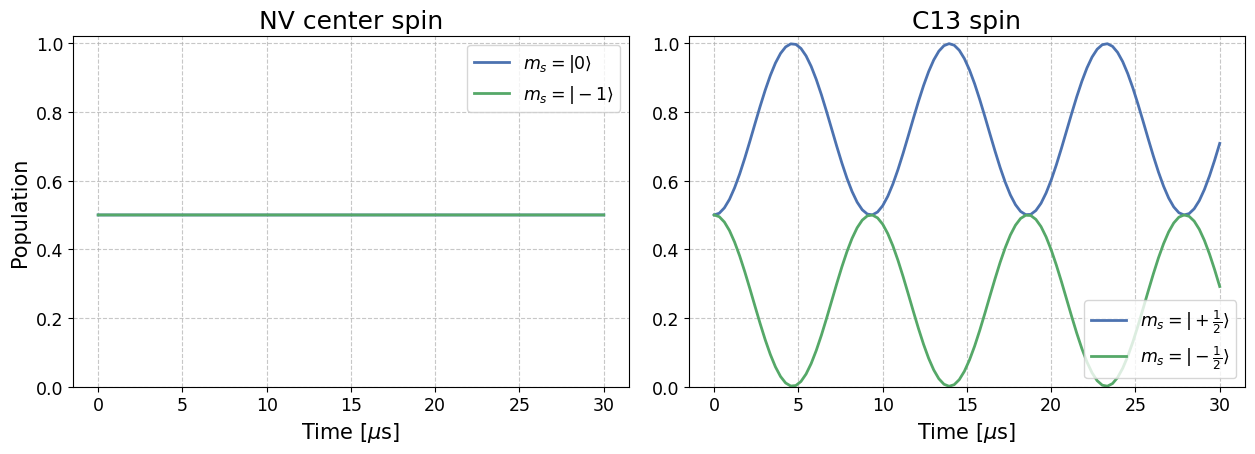

In [3]:
kwargs = dict(env_approx_level='no_bath', suter_method=True, verbose=False, target=bell_state)
env = Environment2(register_config, **kwargs)

env.gate_props_list = [('free_evo', dict(t=30e-6))]
env.old_register_states = [bell_state]
t_list = np.linspace(0, 30e-6, 100)
    
states = env.calc_states(t_list=t_list)[0,:]
fig, ax = plot_pops(t_list, states)

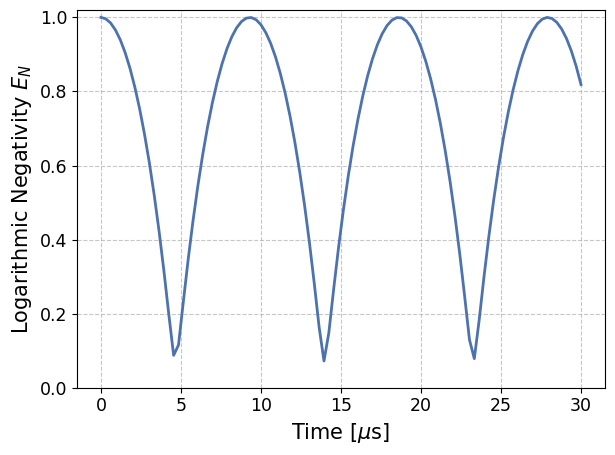

In [4]:
log_negativities = [calc_logarithmic_negativity(state) for state in states] 
fig, ax = plot_log_negativity(t_list, log_negativities)

### Results for different approximation levels

In [ ]:
# no_bath
fig, ax = plot_exp_values(t_list, states)

In [ ]:
# gCCE0
fig, ax = plot_exp_values(t_list, states)

In [ ]:
# gCCE1
fig, ax = plot_exp_values(t_list, states)

In [ ]:
# full_bath thermal
fig, ax = plot_exp_values(t_list, states)

## Hahn echos

In [14]:
C13_pos = (8.728883757198979e-10, 0.0, 1.8558998769620693e-10) # Dominik
register_config = [('NV', (0, 0, 0), 0, {}), ('C13', C13_pos, 0, {})]

kwargs = dict(suter_method=True, verbose=False, target=bell_state, thermal_bath=False)
env = Environment2(register_config, **kwargs)

env.gate_props_list = [
    ("free_evo", dict(t=0.e-6)),
    ("inst_rot", dict(alpha=0.99813568, phi=0.69459264)),
    ("free_evo", dict(t=4.06620465e-6)),
    ("inst_rot", dict(alpha=3.57557112, phi=1.97327426)),
    ("free_evo", dict(t=1.57022726e-6)),
    ("inst_rot", dict(alpha=1.68300382, phi=0.50816523)),
    ("free_evo", dict(t=1.50788214e-6)),
]

env.get_values('fidelity')[0, 0]

array([0.99980934])

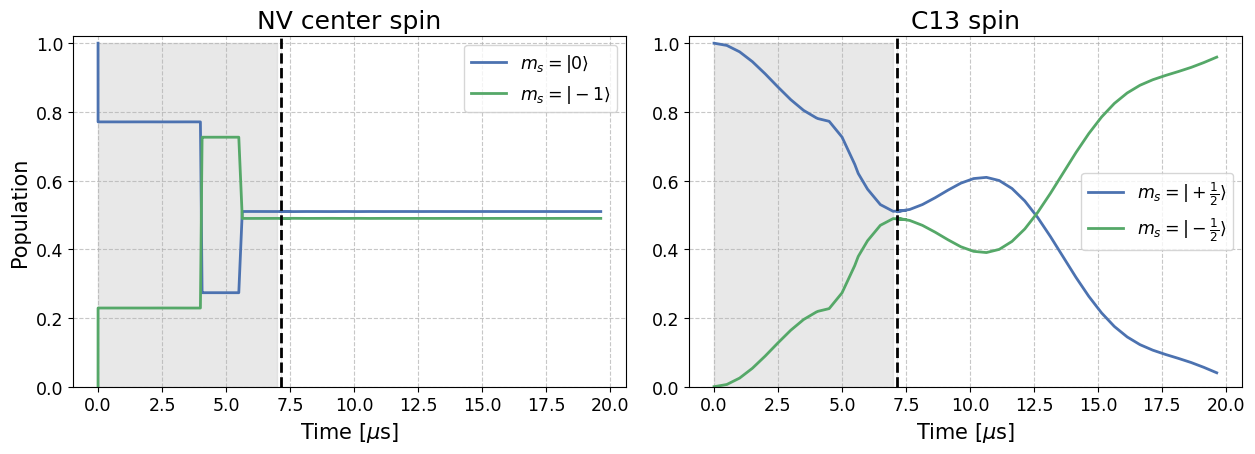

In [15]:
env.num_hahn_echos = 2
t_list = list(env.get_t_list())
t_list.extend( np.arange(env.total_gate_time, 20e-6, 0.5e-6) )
    
states = env.get_states(t_list=t_list)[0,:,0]
fig, ax = plot_pops(t_list, states, pulse_time=env.total_gate_time)

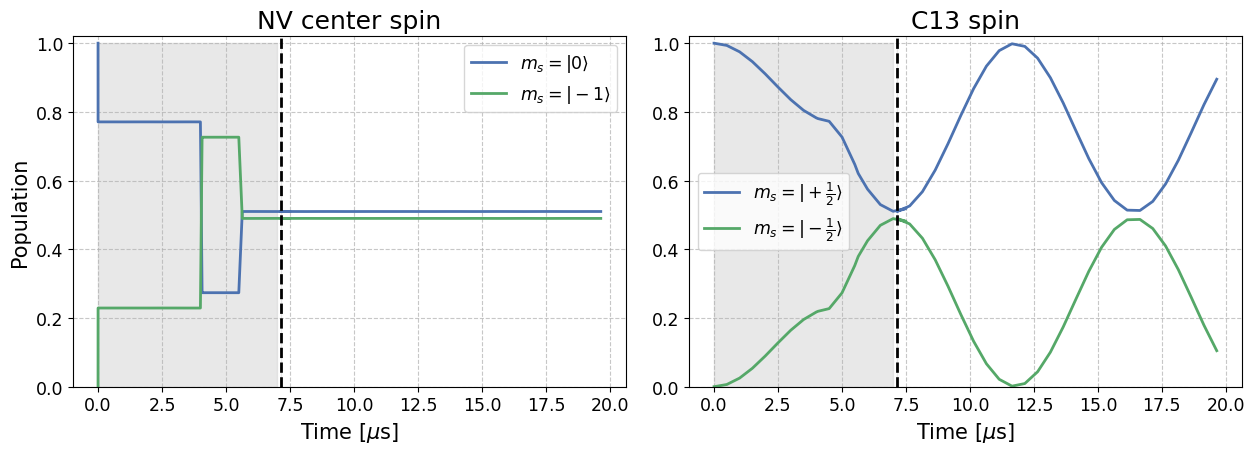

In [16]:
env.num_hahn_echos = 0
t_list = list(env.get_t_list())
t_list.extend( np.arange(env.total_gate_time, 20e-6, 0.5e-6) )
    
states = env.get_states(t_list=t_list)[0,:,0]
fig, ax = plot_pops(t_list, states, pulse_time=env.total_gate_time)

## Bell State Preparation (Dominik, Fig. 4)

In [30]:
C13_pos = (8.728883757198979e-10, 0.0, 1.8558998769620693e-10) # Dominik
register_config = [('NV', (0, 0, 0), 0, {}), ('C13', C13_pos, 0, {})]

directory = os.path.join(os.getcwd(), "baths")
filename = "dominik_bath"
bath_configs_nested = load_spin_baths(filename, directory)
bath_configs = [item for sublist in bath_configs_nested for item in sublist]

kwargs = dict(dm_offset=1e-3, suter_method=True, verbose=False, target=bell_state, thermal_bath=False, env_approx_level='gCCE1', bath_configs=bath_configs)
env = Environment2(register_config, **kwargs)

env.gate_props_list = [
    ("free_evo", dict(t=0.e-6)),
    ("inst_rot", dict(alpha=0.99813568, phi=0.69459264)),
    ("free_evo", dict(t=4.06620465e-6)),
    ("inst_rot", dict(alpha=3.57557112, phi=1.97327426)),
    ("free_evo", dict(t=1.57022726e-6)),
    ("inst_rot", dict(alpha=1.68300382, phi=0.50816523)),
    ("free_evo", dict(t=1.50788214e-6)),
]

# env.calc_values('fidelity')[0, 0]
state = env.calc_states(t_list=[16e-6])[0,0]
calc_logarithmic_negativity(state)

0.8187020796382579

In [31]:
C13_pos = (8.728883757198979e-10, 0.0, 1.8558998769620693e-10) # Dominik
register_config = [('NV', (0, 0, 0), 0, {}), ('C13', C13_pos, 0, {})]

directory = os.path.join(os.getcwd(), "baths")
filename = "dominik_bath"
bath_configs_nested = load_spin_baths(filename, directory)
bath_configs = [item for sublist in bath_configs_nested for item in sublist]

kwargs = dict(dm_offset=1e-3, suter_method=True, verbose=False, target=bell_state, thermal_bath=False, env_approx_level='gCCE0', bath_configs=bath_configs)
env = Environment2(register_config, **kwargs)

env.gate_props_list = [
    ("free_evo", dict(t=0.e-6)),
    ("inst_rot", dict(alpha=0.99813568, phi=0.69459264)),
    ("free_evo", dict(t=4.06620465e-6)),
    ("inst_rot", dict(alpha=3.57557112, phi=1.97327426)),
    ("free_evo", dict(t=1.57022726e-6)),
    ("inst_rot", dict(alpha=1.68300382, phi=0.50816523)),
    ("free_evo", dict(t=1.50788214e-6)),
]

# env.calc_values('fidelity')[0, 0]
state = env.calc_states(t_list=[16e-6])[0,0]
calc_logarithmic_negativity(state)

0.8598321050594142

In [3]:
C13_pos = (8.728883757198979e-10, 0.0, 1.8558998769620693e-10) # Dominik
register_config = [('NV', (0, 0, 0), 0, {}), ('C13', C13_pos, 0, {})]

directory = os.path.join(os.getcwd(), "baths")
filename = "dominik_bath"
bath_configs_nested = load_spin_baths(filename, directory)
bath_configs = [item for sublist in bath_configs_nested for item in sublist]

kwargs = dict(dm_offset=1e-3, suter_method=True, verbose=False, target=bell_state, thermal_bath=True, env_approx_level='full_bath', bath_configs=[bath_configs[0]])
env = Environment2(register_config, **kwargs)

env.gate_props_list = [
    ("free_evo", dict(t=0.e-6)),
    ("inst_rot", dict(alpha=0.99813568, phi=0.69459264)),
    ("free_evo", dict(t=4.06620465e-6)),
    ("inst_rot", dict(alpha=3.57557112, phi=1.97327426)),
    ("free_evo", dict(t=1.57022726e-6)),
    ("inst_rot", dict(alpha=1.68300382, phi=0.50816523)),
    ("free_evo", dict(t=1.50788214e-6)),
]

# env.calc_values('fidelity')[0, 0]
state = env.calc_states(t_list=[16e-6])[0,0]
calc_logarithmic_negativity(state)

0.8187249266603932

In [28]:
C13_pos = (8.728883757198979e-10, 0.0, 1.8558998769620693e-10) # Dominik
register_config = [('NV', (0, 0, 0), 0, {}), ('C13', C13_pos, 0, {})]

directory = os.path.join(os.getcwd(), "baths")
filename = "dominik_bath"
bath_configs_nested = load_spin_baths(filename, directory)
bath_configs = [item for sublist in bath_configs_nested for item in sublist]

kwargs = dict(suter_method=True, verbose=False, target=bell_state, thermal_bath=False, env_approx_level='no_bath', bath_configs=bath_configs)
env = Environment2(register_config, **kwargs)

env.gate_props_list = [
    ("free_evo", dict(t=0.e-6)),
    ("inst_rot", dict(alpha=0.99813568, phi=0.69459264)),
    ("free_evo", dict(t=4.06620465e-6)),
    ("inst_rot", dict(alpha=3.57557112, phi=1.97327426)),
    ("free_evo", dict(t=1.57022726e-6)),
    ("inst_rot", dict(alpha=1.68300382, phi=0.50816523)),
    ("free_evo", dict(t=1.50788214e-6)),
]

# env.calc_values('fidelity')[0, 0]
state = env.calc_states(t_list=[16e-6])[0,0]
calc_logarithmic_negativity(state)

0.9932274060534697

In [ ]:
C13_pos = (8.728883757198979e-10, 0.0, 1.8558998769620693e-10) # Dominik
register_config = [('NV', (0, 0, 0), 0, {}), ('C13', C13_pos, 0, {})]

kwargs = dict(suter_method=True, verbose=False, target=bell_state, thermal_bath=False)
env = Environment2(register_config, **kwargs)

env.gate_props_list = [
    ("free_evo", dict(t=0.e-6)),
    ("inst_rot", dict(alpha=0.99813568, phi=0.69459264)),
    ("free_evo", dict(t=4.06620465e-6)),
    ("inst_rot", dict(alpha=3.57557112, phi=1.97327426)),
    ("free_evo", dict(t=1.57022726e-6)),
    ("inst_rot", dict(alpha=1.68300382, phi=0.50816523)),
    ("free_evo", dict(t=1.50788214e-6)),
]

env.get_values('fidelity')[0, 0]

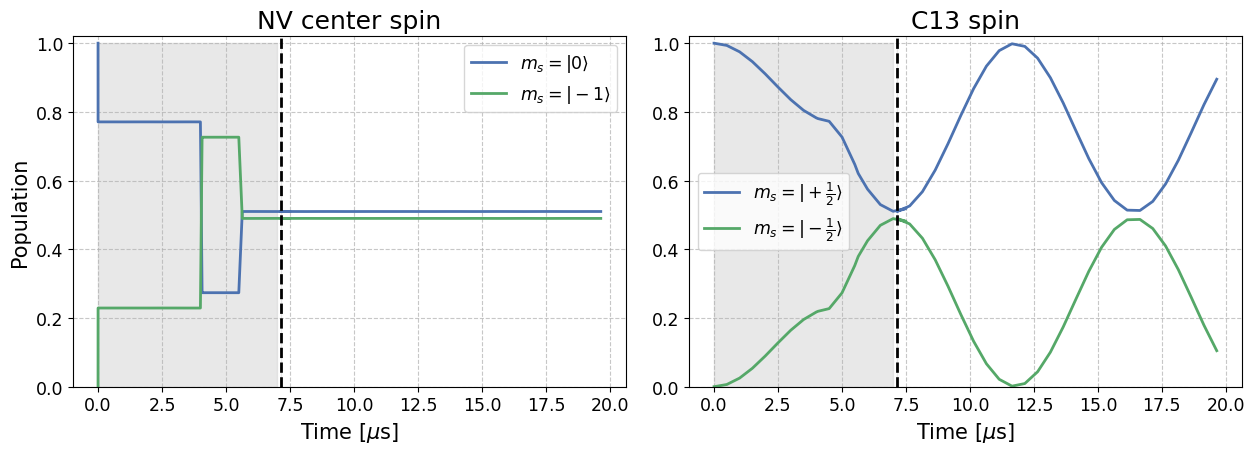

In [18]:
env.num_hahn_echos = 0
t_list = list(env.get_t_list())
t_list.extend( np.arange(env.total_gate_time, 20e-6, 0.5e-6) )
    
states = env.get_states(t_list=t_list)[0,:,0]
fig, ax = plot_pops(t_list, states, pulse_time=env.total_gate_time)

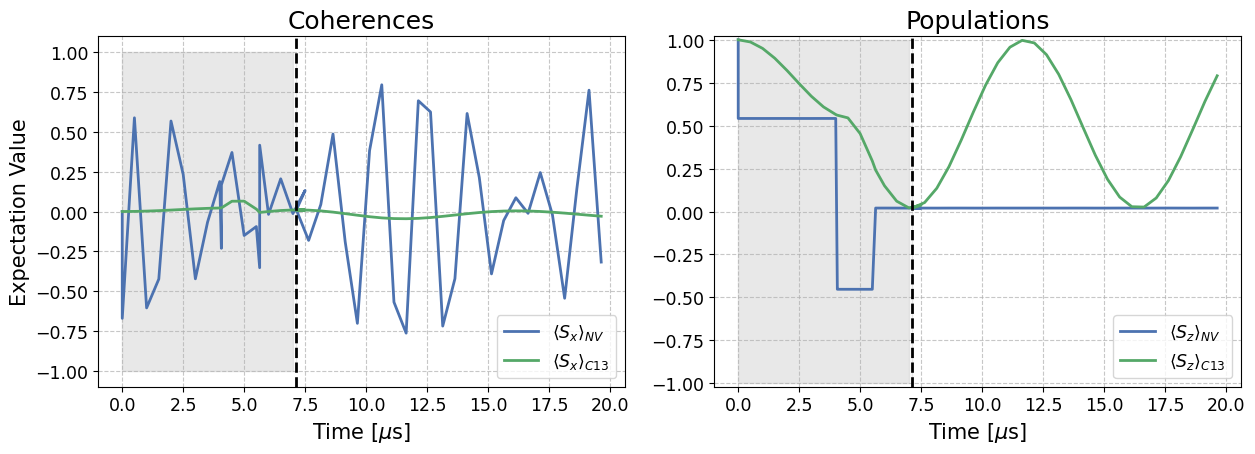

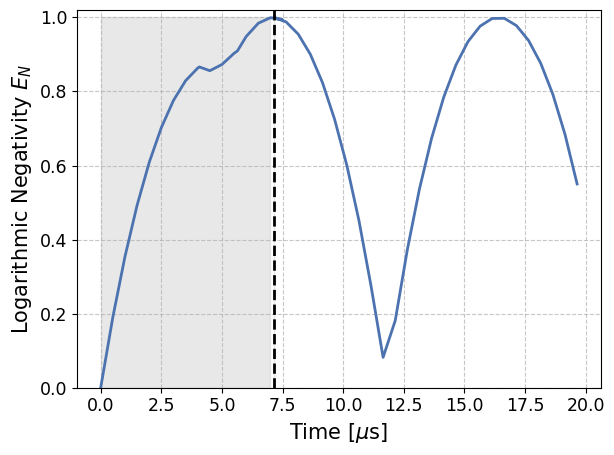

In [19]:
fig, ax = plot_exp_values(t_list, states, pulse_time=env.total_gate_time)

log_negativities = [calc_logarithmic_negativity(state) for state in states] 
fig, ax = plot_log_negativity(t_list, log_negativities, pulse_time=env.total_gate_time)

## Bell State Preparation with Dynamical Decoupling (Dominik, Fig. 7)

In [22]:
C13_pos = (8.728883757198979e-10, 0.0, 1.8558998769620693e-10) # Dominik
register_config = [('NV', (0, 0, 0), 0, {}), ('C13', C13_pos, 0, {})]

kwargs = dict(verbose=False, suter_method=True, target=bell_state, thermal_bath=False)
env = Environment2(register_config, **kwargs)

env.dyn_dec = True
env.gate_props_list = [
    ("free_evo", dict(t=0.e-6, dyn_dec=False)),
    ("inst_rot", dict(alpha=-1.06, phi=-0.53)),
    ("free_evo", dict(t=3.93e-6)),
    ("inst_rot", dict(alpha=4.68, phi=6.26)),
    ("free_evo", dict(t=2.95e-6)),
    ("inst_rot", dict(alpha=2.07, phi=-1.76)),
    ("free_evo", dict(t=2.28e-6)),
    ("inst_rot", dict(alpha=0, phi=0)),
    ("free_evo", dict(t= 0.30e-6)),
]

env.get_values('fidelity')[0, 0]

array([0.99824183])

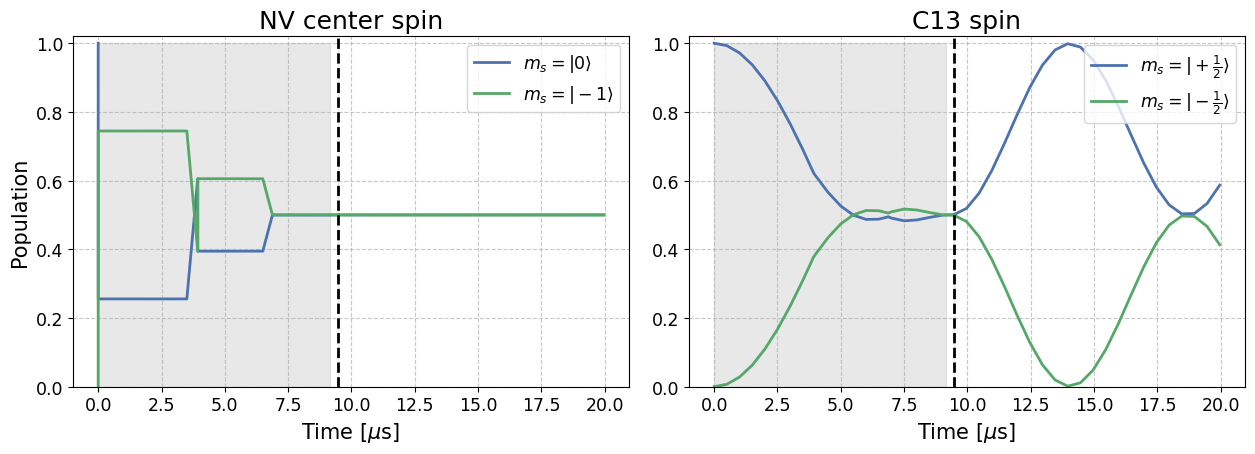

In [23]:
env.num_hahn_echos = 0
t_list = list(env.get_t_list())
t_list.extend( np.arange(env.total_gate_time, 20e-6, 0.5e-6) )
    
states = env.get_states(t_list=t_list)[0,:,0]
fig, ax = plot_pops(t_list, states, pulse_time=env.total_gate_time)

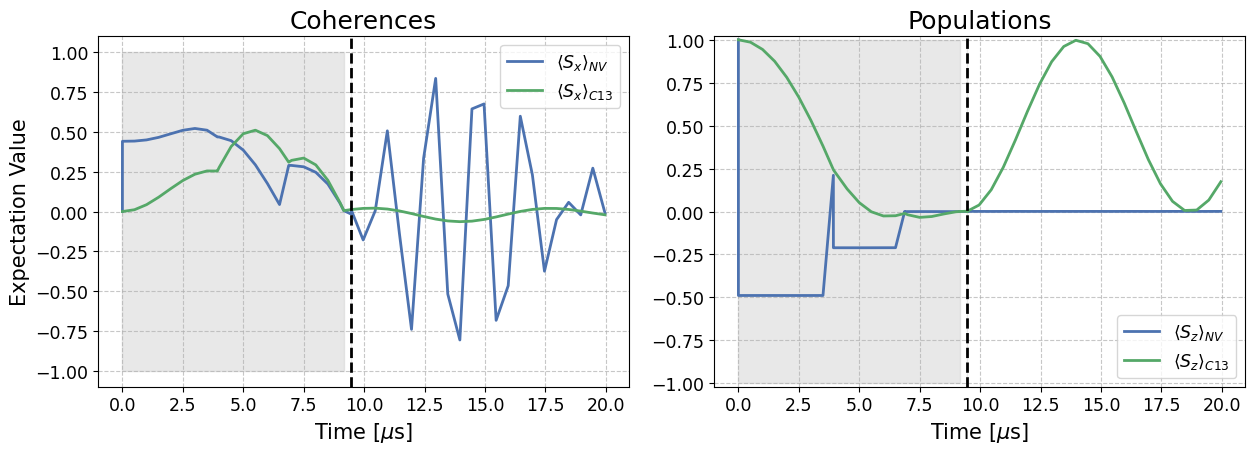

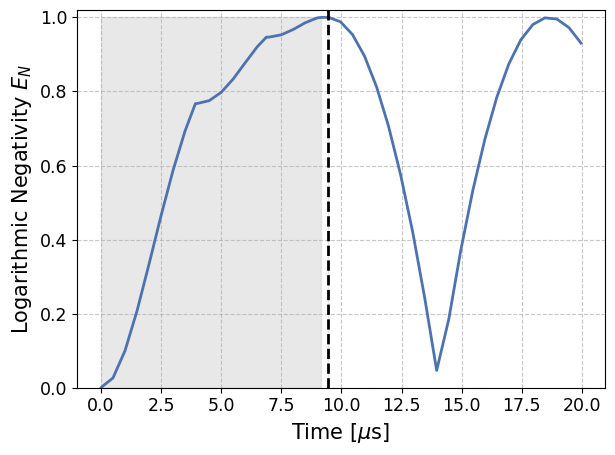

In [24]:
fig, ax = plot_exp_values(t_list, states, pulse_time=env.total_gate_time)

log_negativities = [calc_logarithmic_negativity(state) for state in states] 
fig, ax = plot_log_negativity(t_list, log_negativities, pulse_time=env.total_gate_time)